# Namakan Lake Water Levels

The purpose of this notebook is to create a data series for the water level on Namakan Lake. The data series is written to a file `NL.pkl` that can be read into other notebooks using `NL = pd.read_pickle('./data/NL.pkl')`.

The data series is constructed using data from stations 05PA003 from the Water Survey of Canada.

## Read Data from Water Survey of Canada

The Water Survey of Canada currently maintains a station on Namakan Lake recording lake level. Station 05PA003, located just upstream of Kettle Falls, has been in place since 1911.

The data set is imported into the workspace by running the Water Survey of Canada notebook.

In [1]:
# Display graphics inline with the notebook
%matplotlib notebook

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import requests

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

hydat = pd.HDFStore('../data/hydat.h5')
DLY_LEVELS = hydat['DLY_LEVELS']
DLY_FLOWS = hydat['DLY_FLOWS']
STATIONS = hydat['STATIONS']

def getLevelsWSC(s):
    global DLY_LEVELS
    data = DLY_LEVELS[DLY_LEVELS['STATION_NUMBER'] == s]
    ts = {}
    for k in data.index:
        mo = str(data.ix[k,'MONTH'])
        yr = str(data.ix[k,'YEAR'])
        for n in range(1,data.ix[k,'NO_DAYS']+1):
            ts[pd.to_datetime(mo+'/'+str(n)+'/'+yr)] = data.ix[k,'LEVEL'+str(n)]  
    ts = pd.Series(ts)
    ts.name = STATIONS.ix[s,'STATION_NAME'] + ' (' + s + ')'
    # drop initial and terminal null entries
    j = 0
    while pd.isnull(ts.ix[j]):
        j += 1
    k = len(ts.index) - 1
    while pd.isnull(ts.ix[k]):
        k += -1
    return ts[j:k]

def mapWSC(stationList):
    # returns a .png map image
    S = STATIONS.ix[stationList,['STATION_NAME','LATITUDE','LONGITUDE']]
    locs = ["{0},{1}".format(S.ix[s,'LATITUDE'], S.ix[s,'LONGITUDE']) \
             for s in S.index]
    google_maps_url = \
        "https://maps.googleapis.com/maps/api/staticmap?" + \
        "size=640x320" + \
        "&maptype=terrain" + \
        "&markers=color:red%7Csize:mid%7C" + "|".join(locs)
    img = Image(requests.get(google_maps_url).content)
    display(S)
    return img

,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,
05PA003,NAMAKAN LAKE ABOVE KETTLE FALLS DAM,48.50000,-92.63886
05PA013,NAMAKAN LAKE AT SQUIRREL ISLAND,48.49686,-92.65856


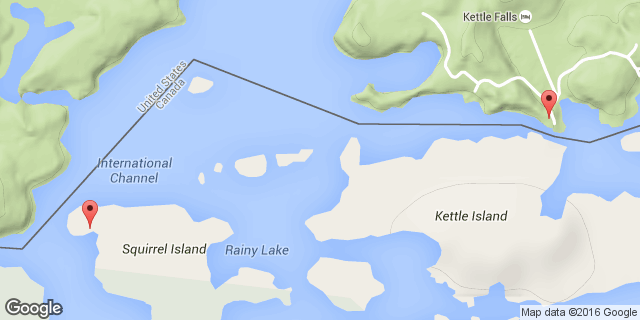

In [2]:
mapWSC(['05PA003','05PA013'])

In [3]:
NL_kf = getLevelsWSC('05PA003')
NL_sq = getLevelsWSC('05PA013')

<IPython.core.display.Javascript object>


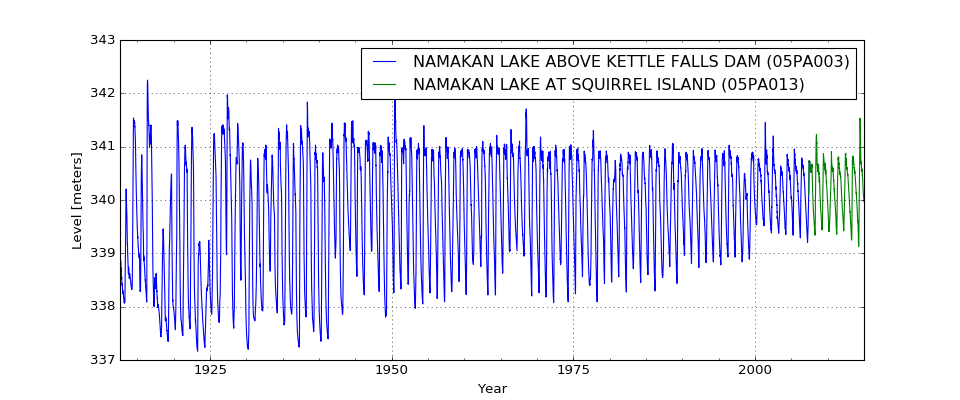

In [4]:
plt.figure(figsize=(12,5))
plt.hold(True)
NL_kf.plot()
NL_sq.plot()
plt.hold(False)
plt.legend([NL_kf.name,NL_sq.name])
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.grid()

## Data Reconciliation

<IPython.core.display.Javascript object>


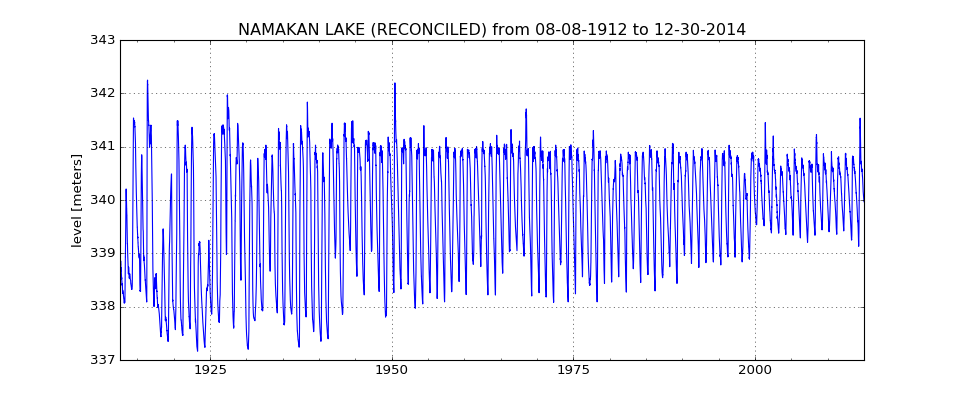

In [5]:
NL = pd.concat([NL_kf,NL_sq])
NL = NL.groupby(NL.index).mean()
NL.name = 'NAMAKAN LAKE (RECONCILED)'

fig,ax = plt.subplots(1,1,figsize=(12,5))
NL.plot()
plt.ylabel('level [meters]')
plt.title(NL.name \
          + ' from ' + NL.index.min().strftime('%m-%d-%Y') \
          + ' to ' + NL.index.max().strftime('%m-%d-%Y'))
plt.grid()

## Writing the Namakan Lake Level Data Series to a File

In [6]:
NL.to_pickle('../data/NL.pkl')